In [1]:
import numpy as np
import pandas as pd

## Introduction

 This dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms. The Argus, Bro-IDS tools are used and twelve algorithms are developed to generate totally 49 features with the class label. These features are described in the UNSW-NB15_features.csv file.

 The majority class is normal.

In [2]:

from pathlib import Path


# Update with correct path - using forward slashes or Path for cross-platform compatibility
data_path = Path("data/unbalance_data.csv")


df = pd.read_csv(data_path)
display(df.head(10))


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
5,6,0.380537,tcp,-,FIN,10,6,534,268,39.417980,...,1,40,0,0,0,2,39,0,Normal,0
6,7,0.637109,tcp,-,FIN,10,8,534,354,26.683033,...,1,40,0,0,0,1,39,0,Normal,0
7,8,0.521584,tcp,-,FIN,10,8,534,354,32.593026,...,1,40,0,0,0,3,39,0,Normal,0
8,9,0.542905,tcp,-,FIN,10,8,534,354,31.313031,...,1,40,0,0,0,3,39,0,Normal,0
9,10,0.258687,tcp,-,FIN,10,6,534,268,57.985135,...,1,40,0,0,0,3,39,0,Normal,0


In [3]:
# EDA for `attack_cat` column: counts, percent, imbalance ratio
col = 'attack_cat'
# value counts (include NaNs if any)
counts = df[col].value_counts(dropna=False)
percent = counts / len(df) * 100
import numpy as np
# build a concise result dataframe
result = pd.DataFrame({'count': counts, 'percent': percent.round(3)})
display(result)
total = len(df)
# majority and minority (ignore zero-count classes)
majority = counts.max()
minority = counts[counts>0].min() if (counts>0).any() else 0
imbalance_ratio = majority / minority if minority>0 else np.nan
majority_prop = majority / total
print(f'Total samples: {total}')
print(f'Majority class: {counts.idxmax()} ({majority} samples, {majority_prop:.4f} proportion)')
print(f'Minority class: {counts.idxmin()} ({minority} samples)')
print(f'Imbalance ratio (majority/minority): {imbalance_ratio:.2f}')


,count,percent
attack_cat,,
Normal,56000,31.938
Generic,40000,22.813
Exploits,33393,19.045
Fuzzers,18184,10.371
DoS,12264,6.994
Reconnaissance,10491,5.983
Analysis,2000,1.141
Backdoor,1746,0.996
Shellcode,1133,0.646


Total samples: 175341
Majority class: Normal (56000 samples, 0.3194 proportion)
Minority class: Worms (130 samples)
Imbalance ratio (majority/minority): 430.77


In [4]:
# Keep only numeric columns and the attack_cat column
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cols_to_keep = numeric_cols + ['attack_cat']
df = df[cols_to_keep]
print(f"Kept {len(cols_to_keep)} columns: {len(numeric_cols)} numeric + attack_cat")

# drop the id column
df = df.drop(columns=['id'])
display(df.head())

Kept 42 columns: 41 numeric + attack_cat


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,1,1,0,0,0,1,1,0,0,Normal
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,1,2,0,0,0,1,6,0,0,Normal
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,1,3,0,0,0,2,6,0,0,Normal
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,1,3,1,1,0,2,1,0,0,Normal
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,1,40,0,0,0,2,39,0,0,Normal


In [6]:
# Standardize only numeric columns with more than 20 unique values (continuous data)
from sklearn.preprocessing import StandardScaler


# Get numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Filter columns with more than 20 unique values (likely continuous)
cols_to_scale = [col for col in numeric_cols if df[col].nunique() > 40]
cols_not_scaled = [col for col in numeric_cols if df[col].nunique() <= 40]

# Standardize only continuous columns
scaler = StandardScaler()
df_clean = df.copy()
df_clean[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

print(f"Standardized {len(cols_to_scale)} columns (>20 unique values)")
print(f"Not standardized {len(cols_not_scaled)} columns (<=20 unique values): {cols_not_scaled}")

# encode attack clo with 1,2,3...
df['attack_cat_encode'] = df['attack_cat'].astype('category').cat.codes

num_indices = [df.columns.get_loc(col) for col in cols_to_scale]
cat_indices = [df.columns.get_loc(col) for col in cols_not_scaled]
print("Categorical column indices:", ",".join(map(str, cat_indices)))
print("Continuous/Numeric columns:", ",".join(map(str, num_indices)))
display(df.head())

Standardized 28 columns (>20 unique values)
Not standardized 12 columns (<=20 unique values): ['sttl', 'dttl', 'swin', 'dwin', 'trans_depth', 'ct_state_ttl', 'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports', 'label']
Categorical column indices: 6,7,16,19,25,28,31,33,34,35,38,39
Continuous/Numeric columns: 0,1,2,3,4,5,8,9,10,11,12,13,14,15,17,18,20,21,22,23,24,26,27,29,30,32,36,37


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label,attack_cat,attack_cat_encode
0,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,1,0,0,0,1,1,0,0,Normal,6
1,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,2,0,0,0,1,6,0,0,Normal,6
2,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,3,0,0,0,2,6,0,0,Normal,6
3,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,3,1,1,0,2,1,0,0,Normal,6
4,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,40,0,0,0,2,39,0,0,Normal,6


In [7]:
# save dataset
df.to_csv("data/unbalanced_data_standardized.csv", index=False)

In [ ]:
# Print categorical and numeric column information based on unique value threshold
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Filter columns with more than 40 unique values (continuous/numeric)
continuous_cols = [col for col in numeric_cols if df[col].nunique() > 40]
# Filter columns with ≤40 unique values (categorical)
cat_cols = [col for col in numeric_cols if df[col].nunique() <= 40]

# Get indices of categorical columns
cat_indices = [df.columns.get_loc(col) for col in cat_cols]
print("Categorical column indices:", ",".join(map(str, cat_indices)))

# Print continuous/numeric columns
print("Continuous/Numeric columns:", continuous_cols)

Categorical column indices: 2,3,4,43
Numeric columns: ['id', 'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the first 40 numeric columns for PCA
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features_for_pca = numeric_cols[:40]
print(f"Using {len(features_for_pca)} features for PCA")

# Extract features and normalize
X = df[features_for_pca].values
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)
print("Data normalized with StandardScaler")

# Perform PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_normalized)

# Create dataframe with PCA results
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'PC3': X_pca[:, 1],
    'attack_cat': df['attack_cat'].values
})

print(f"Explained variance ratio: PC1={pca.explained_variance_ratio_[0]:.4f}, PC2={pca.explained_variance_ratio_[1]:.4f}, PC3={pca.explained_variance_ratio_[2]:.4f}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.4f}")

Using 40 features for PCA
Data normalized with StandardScaler
Explained variance ratio: PC1=0.2558, PC2=0.0965, PC3=0.0924
Total explained variance: 0.4446


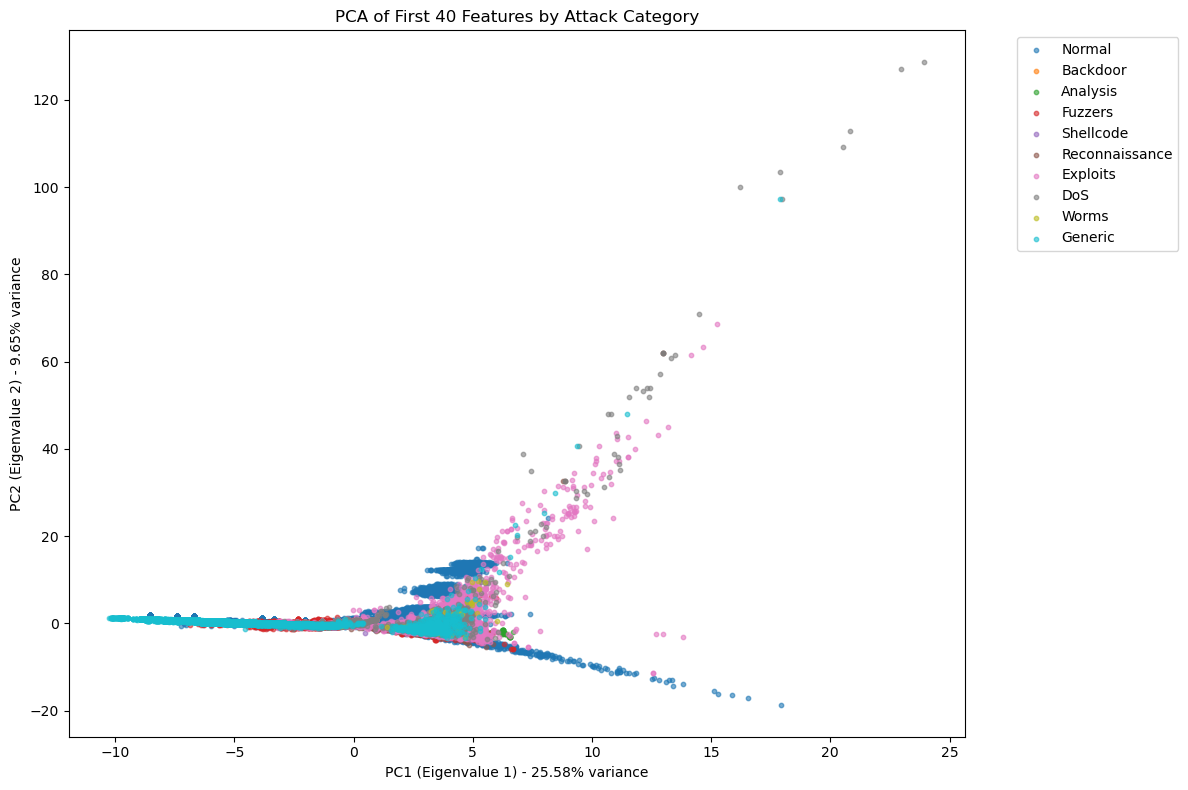

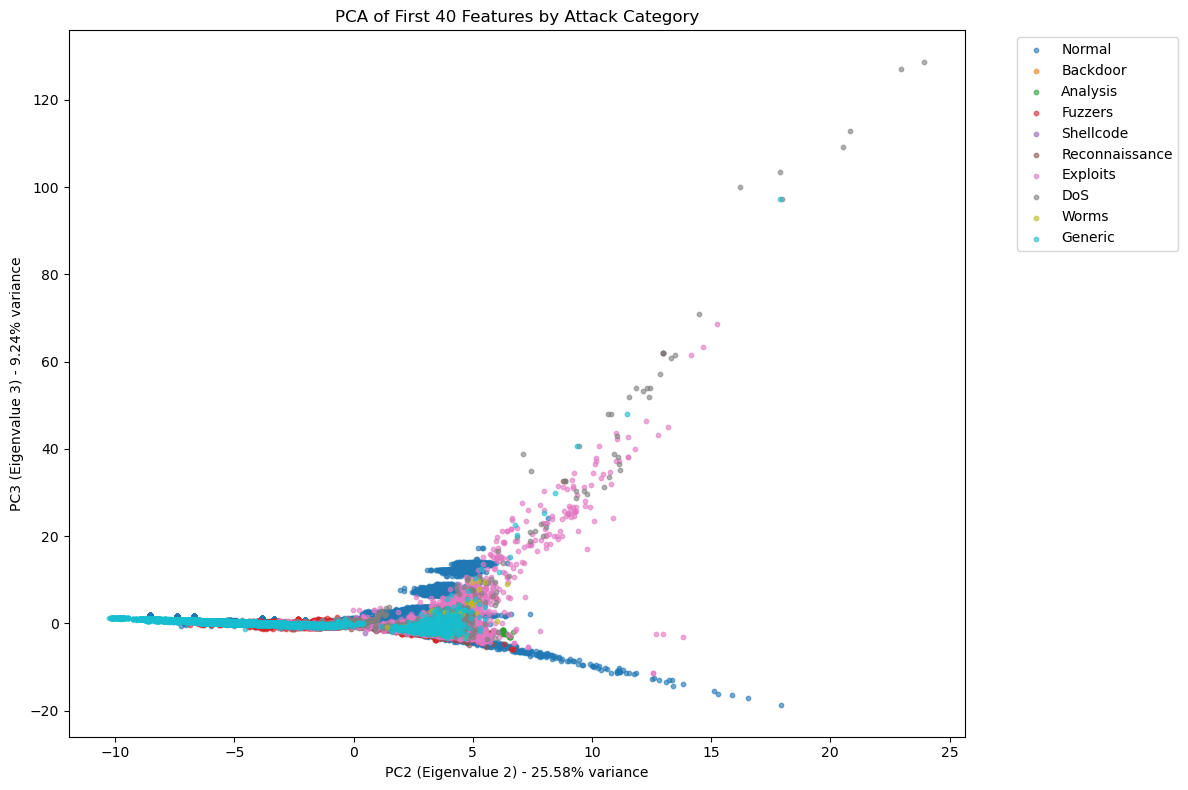

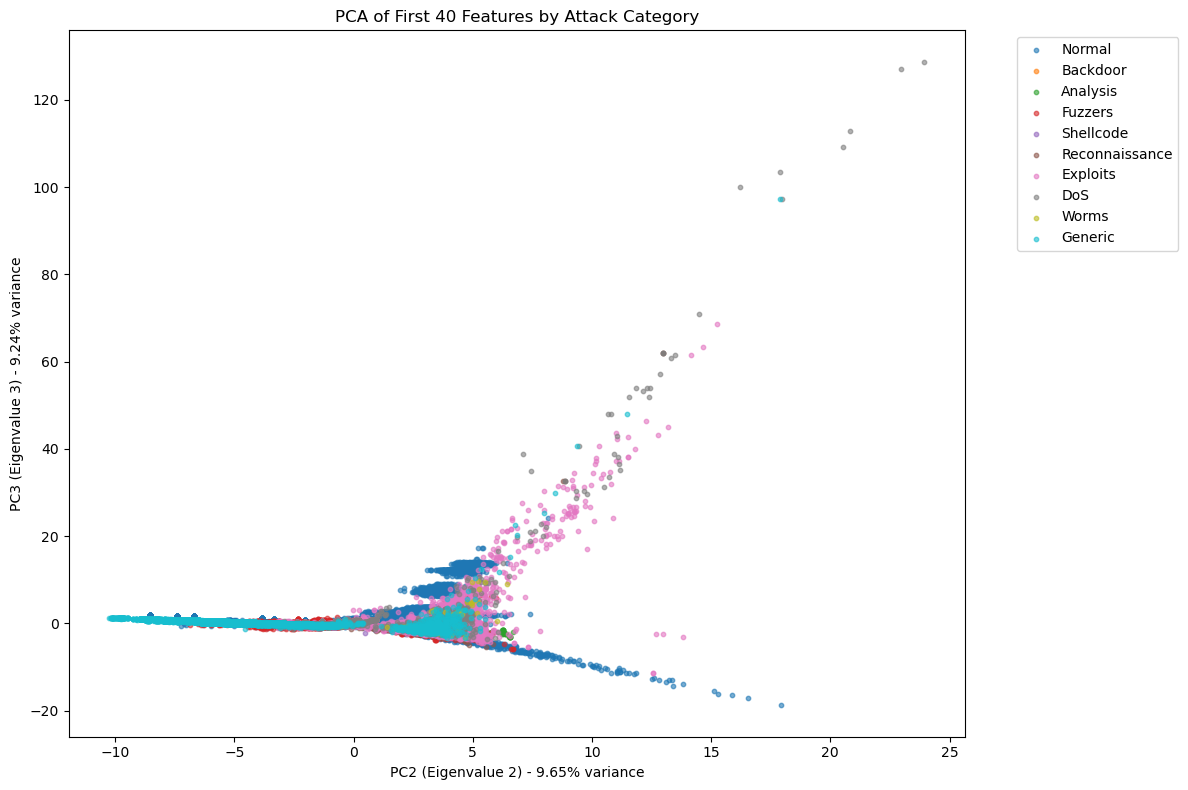

In [21]:
# Plot PCA results: PC1 vs PC2 colored by attack category
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique classes and assign colors
classes = pca_df['attack_cat'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

for i, cls in enumerate(classes):
    mask = pca_df['attack_cat'] == cls
    ax.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC2'], 
               c=[colors[i]], label=cls, alpha=0.6, s=10)

ax.set_xlabel(f'PC1 (Eigenvalue 1) - {pca.explained_variance_ratio_[0]*100:.2f}% variance')
ax.set_ylabel(f'PC2 (Eigenvalue 2) - {pca.explained_variance_ratio_[1]*100:.2f}% variance')
ax.set_title('PCA of First 40 Features by Attack Category')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot PCA results: PC1 vs PC3 colored by attack category
fig, ax = plt.subplots(figsize=(12, 8))
 
# Get unique classes and assign colors
classes = pca_df['attack_cat'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

for i, cls in enumerate(classes):
    mask = pca_df['attack_cat'] == cls
    ax.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC3'], 
               c=[colors[i]], label=cls, alpha=0.6, s=10)

ax.set_xlabel(f'PC2 (Eigenvalue 2) - {pca.explained_variance_ratio_[0]*100:.2f}% variance')
ax.set_ylabel(f'PC3 (Eigenvalue 3) - {pca.explained_variance_ratio_[2]*100:.2f}% variance')
ax.set_title('PCA of First 40 Features by Attack Category')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot PCA results: PC2 vs PC3 colored by attack category
fig, ax = plt.subplots(figsize=(12, 8))

# Get unique classes and assign colors
classes = pca_df['attack_cat'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(classes)))

for i, cls in enumerate(classes):
    mask = pca_df['attack_cat'] == cls
    ax.scatter(pca_df.loc[mask, 'PC1'], pca_df.loc[mask, 'PC3'], 
               c=[colors[i]], label=cls, alpha=0.6, s=10)

ax.set_xlabel(f'PC2 (Eigenvalue 2) - {pca.explained_variance_ratio_[1]*100:.2f}% variance')
ax.set_ylabel(f'PC3 (Eigenvalue 3) - {pca.explained_variance_ratio_[2]*100:.2f}% variance')
ax.set_title('PCA of First 40 Features by Attack Category')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# save df
pca_df.to_csv("data/pca_unbalanced_data.csv", index=False)